<a href="https://colab.research.google.com/github/denihong/EscolaDNC_Desafio-7/blob/main/Desafio_7_Crie_um_modelo_de_an%C3%A1lise_das_m%C3%A9tricas_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

Uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:


-Clientes que compram os mesmos produtos;

-Clientes que possuem a mesma frequência de compras;

-Clientes que gastam mais dinheiro em suas compras;


A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.



# Data Understanding

* Carregue a base de dados;
* Descrição estatística dos dados;
* Verifique a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados;



In [ ]:
# Setup
%%capture
%pip install sidetable


In [ ]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer, SilhouetteVisualizer


In [ ]:
df = pd.read_csv('/content/data.csv', encoding='latin-1')

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df[['InvoiceNo','StockCode','Description','CustomerID','Country']].nunique()


,0
InvoiceNo,25900
StockCode,4070
Description,4223
CustomerID,4372
Country,38


<Axes: ylabel='Country'>

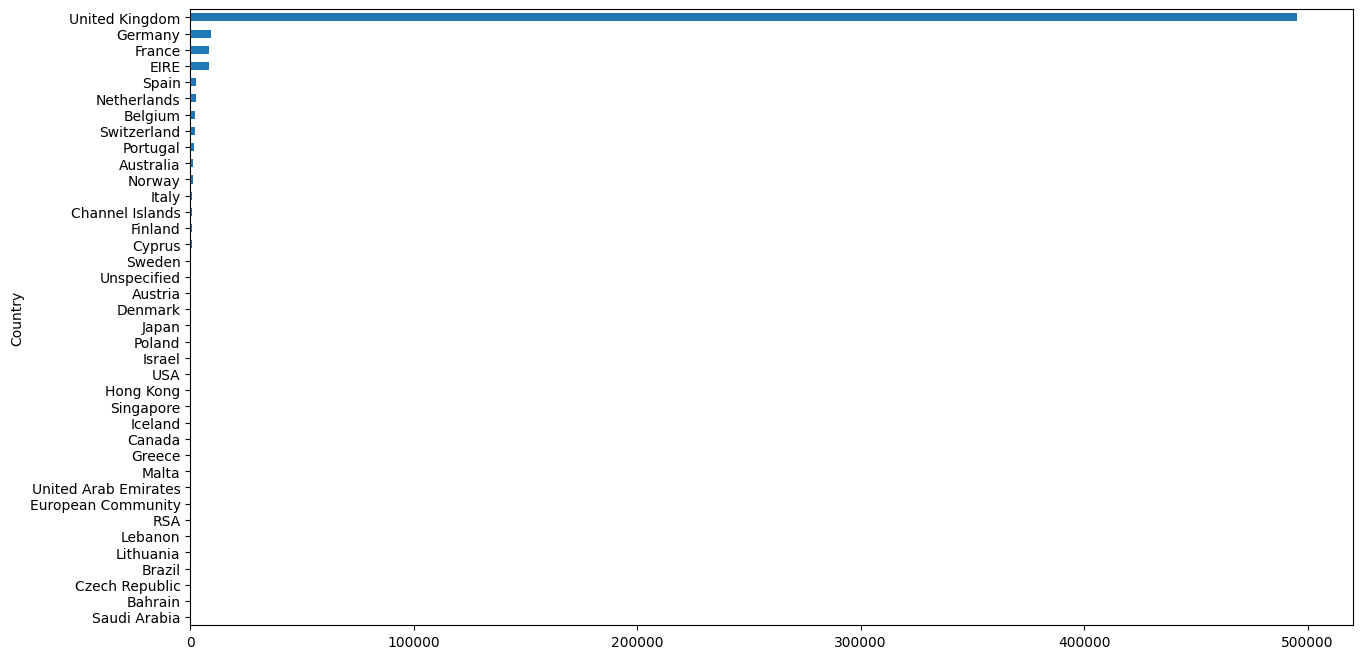

In [ ]:
df['Country'].value_counts(ascending=True).plot.barh(figsize=(15,8))

In [ ]:
df.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.duplicated().sum()

5268

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Pré-processamento dos dados

* Realize a normalização dos dados;
* Faça uma seleção das variáveis mais relevantes para o modelo;
* Remova os dados nulos, duplicados, outliers e inconsistentes

In [ ]:
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


In [ ]:
df = df.dropna(subset=['CustomerID'])

In [ ]:
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


In [ ]:
pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

,InvoiceDate
0,2010-12-01 08:26:00
1,2010-12-01 08:26:00
2,2010-12-01 08:26:00
3,2010-12-01 08:26:00
4,2010-12-01 08:26:00
...,...
541904,2011-12-09 12:50:00
541905,2011-12-09 12:50:00
541906,2011-12-09 12:50:00
541907,2011-12-09 12:50:00


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

<ipython-input-56-0a4a47e6cb3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

<Axes: >

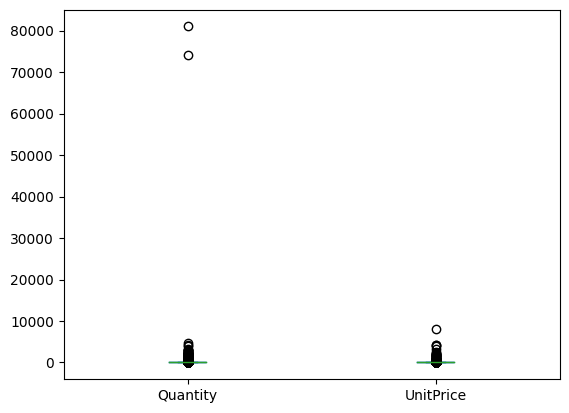

In [ ]:
df[['Quantity','UnitPrice']].plot.box()

In [ ]:
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


<Axes: >

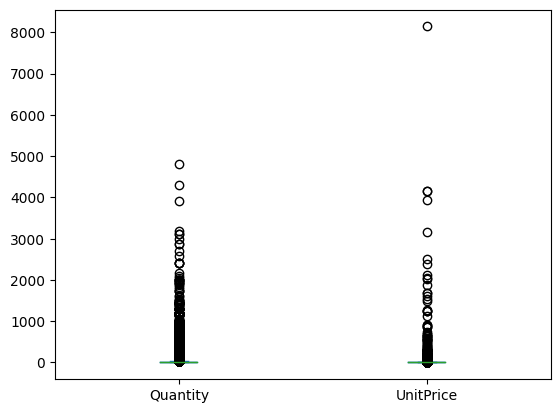

In [ ]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

In [ ]:
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom


In [ ]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

In [ ]:
df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [ ]:
pd.Timestamp.today()


Timestamp('2024-09-04 11:56:33.247713')

In [ ]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347.0,24,7,23.681319
12348.0,97,4,57.975484
12349.0,40,1,24.076027
12350.0,332,1,19.670588
12352.0,58,8,29.482824
...,...,...,...
18280.0,299,1,18.060000
18281.0,202,1,11.545714
18282.0,29,2,14.837500


<Axes: >

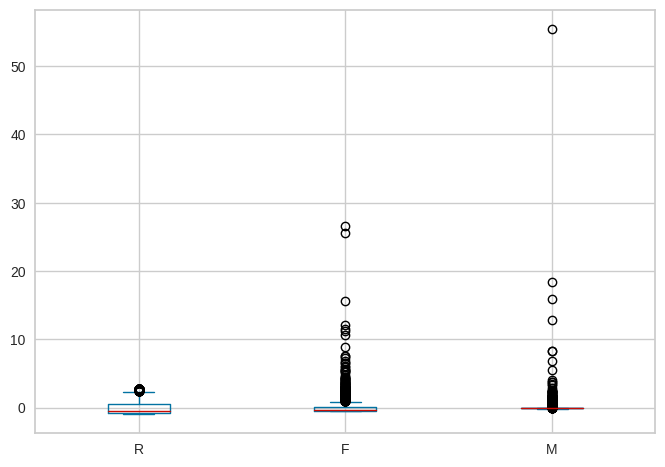

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098.0,0.899878,-0.165317,55.434876


In [ ]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098.0,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom,649.5


In [ ]:
df_rfm = df_rfm.drop(15098)

<Axes: >

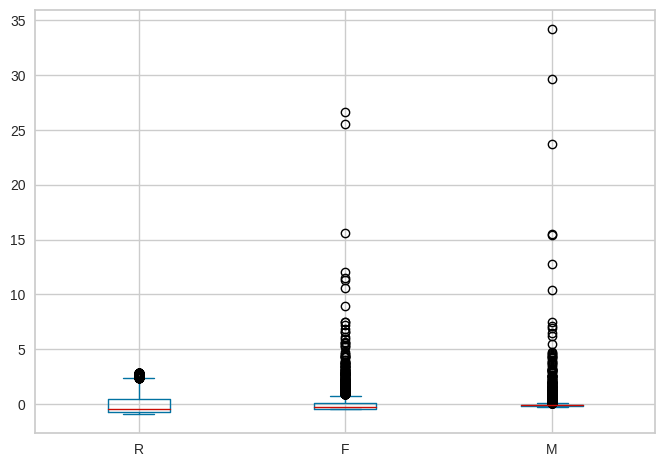

In [ ]:
df_rfm.apply(scale).plot.box()

In [ ]:
scaler = PowerTransformer()

In [ ]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347.0,-1.563219,1.201866,0.407836
12348.0,0.323470,0.660670,1.329304
12349.0,-0.809134,-1.158070,0.426829
12350.0,1.568467,-1.158070,0.189376
12352.0,-0.307718,1.309671,0.653411
...,...,...,...
18280.0,1.475652,-1.158070,0.085562
18281.0,1.107356,-1.158070,-0.491003
18282.0,-1.275046,-0.195707,-0.161007


<Axes: >

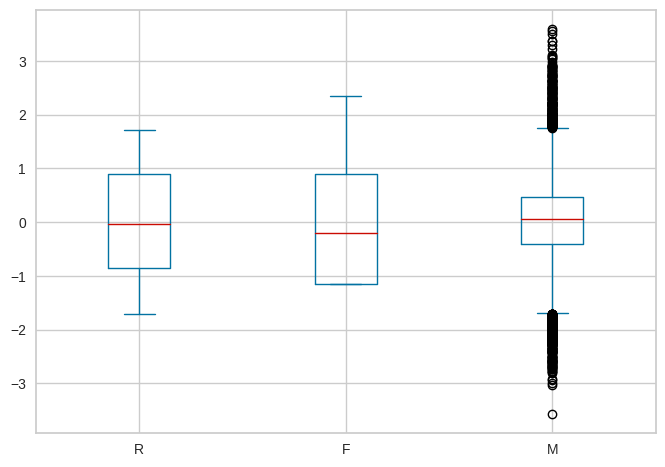

In [ ]:
df_rfm_scaled.plot.box()

In [ ]:
scaler.inverse_transform(df_rfm_scaled)

array([[24.        ,  7.        , 23.68131868],
       [97.        ,  4.        , 57.97548387],
       [40.        ,  1.        , 24.0760274 ],
       ...,
       [29.        ,  2.        , 14.8375    ],
       [25.        , 16.        ,  2.77100529],
       [64.        ,  3.        , 26.24685714]])

In [ ]:
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


In [ ]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [ ]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

#K-MEANS

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

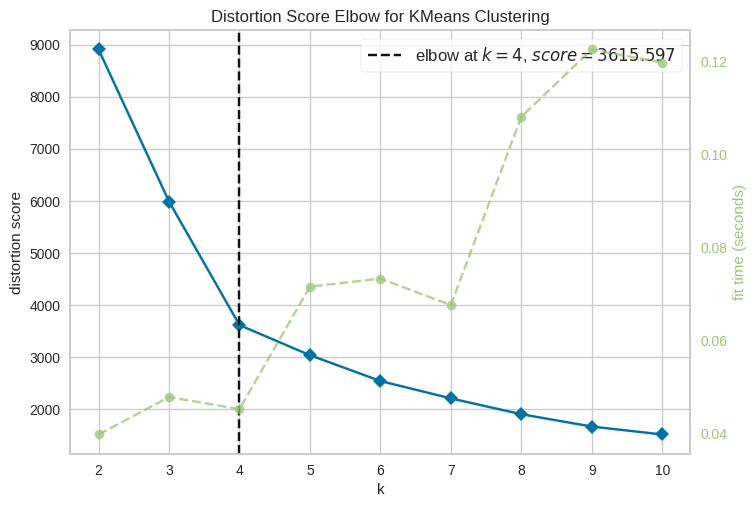

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [ ]:
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10)


In [ ]:
model = KMeans(4, random_state=0).fit(df_rfm_clip_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
centroids = model.cluster_centers_
labels = model.labels_

array([<Axes: title={'center': 'Grupo_0'}>,
       <Axes: title={'center': 'Grupo_1'}>,
       <Axes: title={'center': 'Grupo_2'}>,
       <Axes: title={'center': 'Grupo_3'}>], dtype=object)

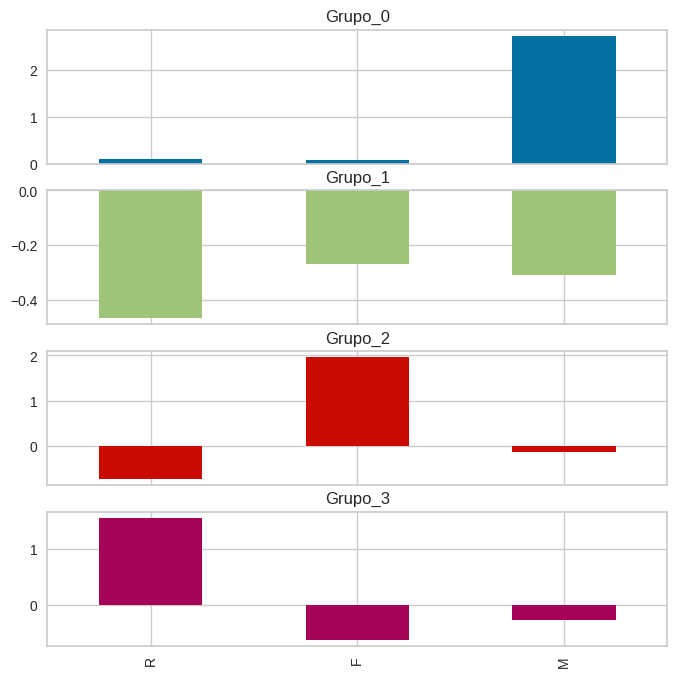

In [ ]:
(
  pd.DataFrame(centroids, columns=df_rfm_clip_scaled.columns)
  .T.add_prefix('Grupo_')
  .plot.bar(subplots=True,figsize=(8,8), legend=False)
)

# Perfil de compras dos clientes para cada cluster, com base nos centróides:

## Grupo 0 :
* Recência (R): Baixa — Clientes desse grupo compraram recentemente.
* Frequência (F): Baixa — Frequencia baixa inidica que os clientes não compram com frequência.
* Valor Monetário (M): Alto — Clientes deste grupo gastam mais dinheiro em suas compras.

## Grupo 1 :
* Recência (R): Baixa — Significa que eles compraram recentemente.
* Frequência (F): Baixa — Eeste grupo Não compram com frequência.
* Valor Monetário (M): Baixo — clientes deste grupo gastam pouco dinheiro em suas compras.

##Grupo 2 :
* Recência (R): Baixa — Clientes compraram recentemente.
* Frequência (F): Alta — Um valor mais alto sugere que os clientes compram com mais frequência.
* Valor Monetário (M): Baixo — Um valor baixo indica menor gasto.


##Grupo 3 :
* Recência (R): Alta — Clientes que compraram há mais tempo terão um valor alto de recência.
* Frequência (F): Baixa — Clientes com um valor baixo de frequência compram raramente.
* Valor Monetário (M): Baixo — Clientes com baixo valor, tendem a gastar menos.

# Análise com K-means
O K-means é um algoritmo de agrupamento que organiza dados em grupos (ou clusters) com base em suas características. Cada grupo contém elementos semelhantes entre si, e diferentes dos elementos de outros grupos. Aqui está como isso pode ser útil:

* Segmentação de Clientes: Usando K-means, uma empresa pode identificar segmentos de clientes que têm comportamentos ou características semelhantes. Por exemplo, a empresa pode descobrir que há grupos de clientes que compram com alta frequência, outros que fazem compras de alto valor, e outros que são mais esporádicos. Isso permite que a empresa crie campanhas específicas para cada grupo.
* Personalização das Campanhas: Com base na classificação RFM, a empresa pode criar campanhas direcionadas. Por exemplo, clientes que gastam muito (alta pontuação em Monetário) mas que não compram frequentemente (baixa pontuação em Frequência) podem ser alvos de campanhas que incentivem compras adicionais.

* Identificação de Oportunidades de Crescimento: Clientes com alta pontuação em Recência e Frequência, mas baixa em Monetário, podem ser incentivados a aumentar o valor de suas compras. Por outro lado, clientes com alta pontuação em Monetário e Frequência podem ser alvo de campanhas de fidelização para manter o engajamento.

# Análise RFM
O modelo RFM (Recency, Frequency, Monetary) avalia os clientes com base em três critérios:

* Recência (R): Há quanto tempo o cliente fez sua última compra.
* Frequência (F): Com que frequência o cliente faz compras.
* Monetário (M): Quanto o cliente gasta em média.


Claro! Vamos explorar como a análise de clientes usando métodos como K-means e RFM pode beneficiar uma empresa na segmentação e personalização das campanhas de marketing.

1. Análise com K-means
O K-means é um algoritmo de agrupamento que organiza dados em grupos (ou clusters) com base em suas características. Cada grupo contém elementos semelhantes entre si, e diferentes dos elementos de outros grupos. Aqui está como isso pode ser útil:

Segmentação de Clientes: Usando K-means, uma empresa pode identificar segmentos de clientes que têm comportamentos ou características semelhantes. Por exemplo, a empresa pode descobrir que há grupos de clientes que compram com alta frequência, outros que fazem compras de alto valor, e outros que são mais esporádicos. Isso permite que a empresa crie campanhas específicas para cada grupo.

Personalização das Campanhas: Conhecendo os grupos identificados, a empresa pode personalizar suas campanhas de marketing para atender às preferências e comportamentos de cada segmento. Por exemplo, campanhas de fidelização podem ser direcionadas para clientes frequentes, enquanto ofertas especiais podem ser feitas para clientes de alto valor.

Eficiência no Uso de Recursos: Ao direcionar campanhas específicas para diferentes segmentos, a empresa pode otimizar o uso do orçamento de marketing, evitando o desperdício de recursos em campanhas menos eficazes.

2. Análise RFM
O modelo RFM (Recency, Frequency, Monetary) avalia os clientes com base em três critérios:

Recência (R): Há quanto tempo o cliente fez sua última compra.
Frequência (F): Com que frequência o cliente faz compras.
Monetário (M): Quanto o cliente gasta em média.
Benefícios da Análise RFM:

Segmentação de Clientes: A análise RFM permite que a empresa classifique os clientes em diferentes categorias, como "Clientes Fidelizados", "Clientes Ocasionalmente Ativos", e "Clientes Potenciais". Cada categoria representa um nível diferente de engajamento e valor.

Personalização das Campanhas: Com base na classificação RFM, a empresa pode criar campanhas direcionadas. Por exemplo, clientes que gastam muito (alta pontuação em Monetário) mas que não compram frequentemente (baixa pontuação em Frequência) podem ser alvos de campanhas que incentivem compras adicionais.

Identificação de Oportunidades de Crescimento: Clientes com alta pontuação em Recência e Frequência, mas baixa em Monetário, podem ser incentivados a aumentar o valor de suas compras. Por outro lado, clientes com alta pontuação em Monetário e Frequência podem ser alvo de campanhas de fidelização para manter o engajamento.

# Integração dos Métodos K-means e RFM
Usar K-means e RFM em conjunto pode proporcionar uma visão mais aprofundada dos clientes:

* K-means pode ajudar a identificar clusters de clientes com características similares, enquanto a análise RFM pode refinar esses clusters ao avaliar a recência, frequência e valor das compras.

* Por exemplo, após usar K-means para segmentar os clientes, a análise RFM pode ser aplicada a cada cluster para entender melhor o comportamento de compra e criar campanhas mais específicas e direcionadas.